# Stock Market Prediction

This notebook shows the example workflow for financial data time series analysis.

In [51]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

## Download Historical Data

Financial time series can be downloaded using the Yahoo! Finance API which becomes easily accessible with the <code>pandas_datareader</code> library.

In [ ]:
# define arguments
tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX', '^GSPC']
provider = 'yahoo'
start = datetime.datetime(2012, 5, 18)
end = datetime.date(2017, 8, 22)

In [2]:
# ask Yahoo! Finance for data and save to DataFrame
data = web.DataReader(tickers, 'yahoo', start, end)['Adj Close']

# save data to a .csv
data.to_csv('./data/stock_data.csv', sep=';')

# show the data
data.head()

In [37]:
data = pd.read_csv('./data/stock_data.csv', sep=';', header=0, parse_dates=True, index_col=0)

In [38]:
data.head()

,AAPL,AMZN,FB,GOOG,NFLX,^GSPC
Date,,,,,,
2012-05-17,68.13225,218.36000,nan,309.51193,10.28143,1304.85999
2012-05-18,68.16567,213.85001,38.23000,298.26010,9.99429,1295.21997
2012-05-21,72.13699,218.11000,34.03000,305.07080,10.24857,1315.98999
2012-05-22,71.58306,215.33000,31.00000,298.45880,9.67286,1316.63000
2012-05-23,73.32967,217.28000,32.00000,302.76083,10.27286,1318.85999


If the <code>DateFrame</code> is not explicitly invoked, this would create a <code>Series</code> object.

In [39]:
# only date and Netflix adjusted closing prices
data = pd.DataFrame(data.loc[:, 'NFLX'])

In [40]:
# rename columns
data.columns = ['prices']

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1325 entries, 2012-05-17 to 2017-08-22
Data columns (total 1 columns):
prices    1325 non-null float64
dtypes: float64(1)
memory usage: 20.7 KB


In [42]:
pd.__version__

'0.20.1'

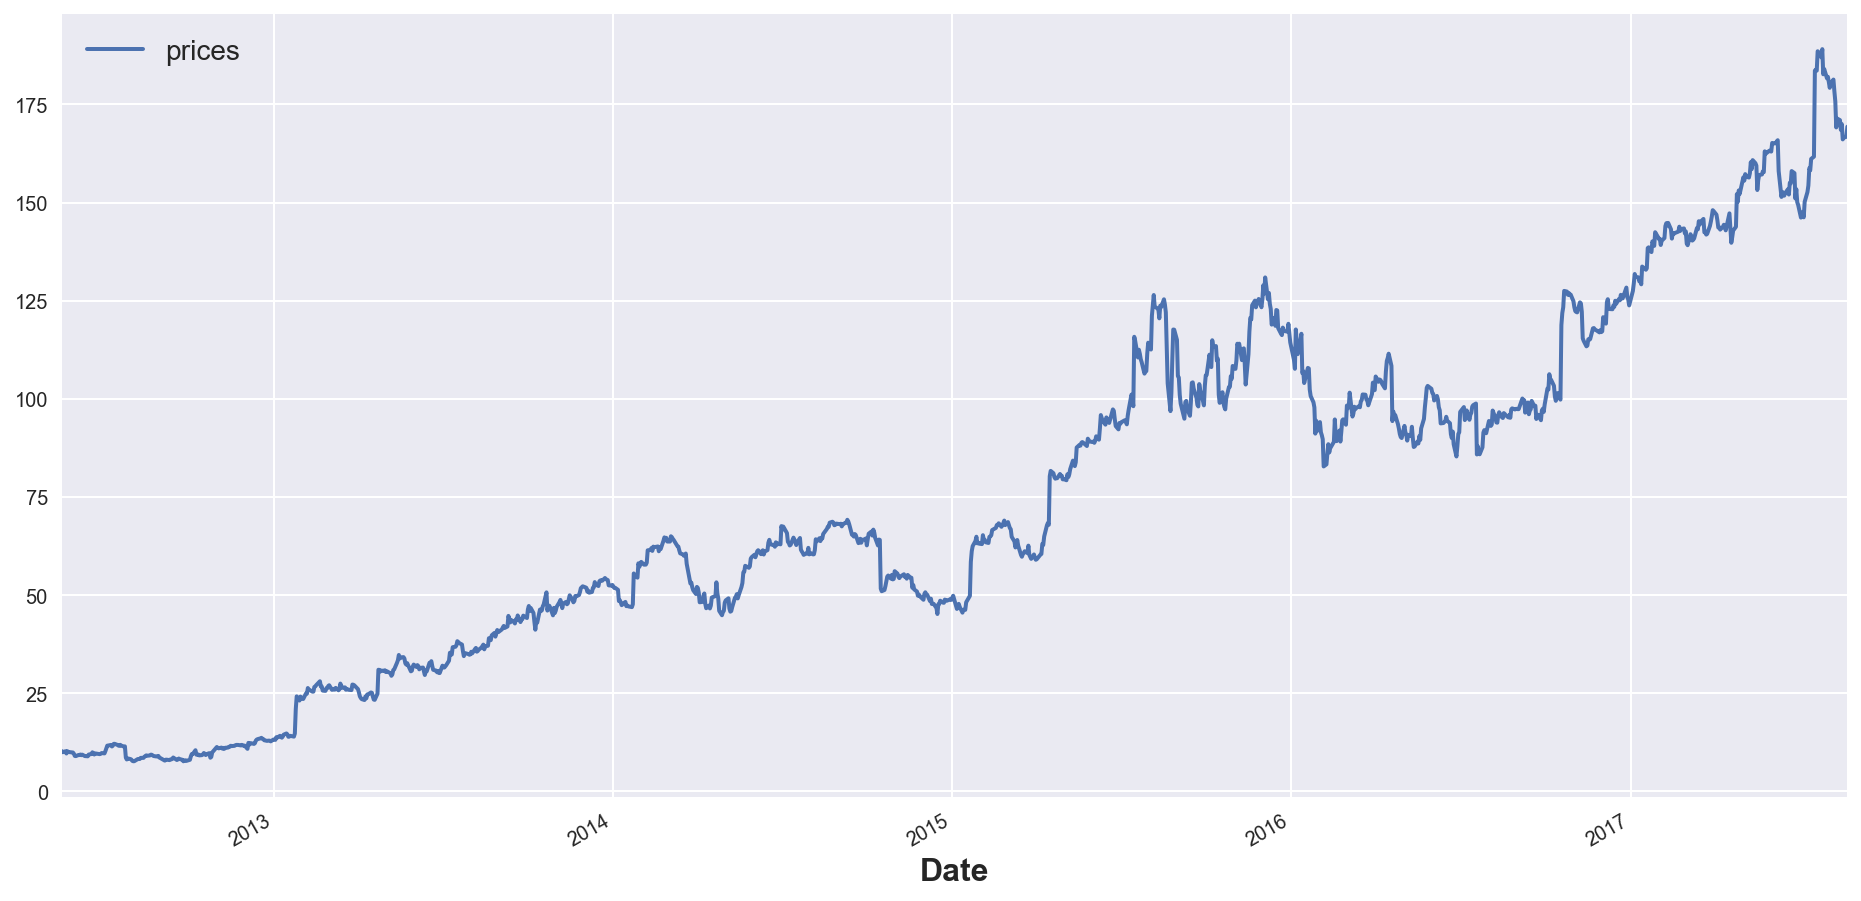

In [43]:
data.plot();

In [44]:
data['returns'] = np.log(data / data.shift(1))

In [45]:
data.head()

,prices,returns
Date,,
2012-05-17,10.28143,nan
2012-05-18,9.99429,-0.02833
2012-05-21,10.24857,0.02512
2012-05-22,9.67286,-0.05781
2012-05-23,10.27286,0.06018


In [1]:
def create_data_set(data, lags=1):
    """
    For given df transform into lagged dataset
    """
    cols = []
    for lag in range(1, lags+1):
        col = 'lag_%d' % lag
        data[col] = data['returns'].shift(lag)
        cols.append(col)
        
    return data, cols

In [2]:
# define lags
lags=5

# create new data
data, cols = create_data_set(data, lags=lags)

NameError: name 'data' is not defined

In [ ]:
data.head(10)

In [49]:
data.dropna(inplace=True)

In [50]:
data.head()

,prices,returns,ret_1,ret_2,ret_3,ret_4,ret_5
Date,,,,,,,
2012-05-25,10.03143,-0.00071,-0.02307,0.06018,-0.05781,0.02512,-0.02833
2012-05-29,9.92000,-0.01117,-0.00071,-0.02307,0.06018,-0.05781,0.02512
2012-05-30,9.62000,-0.03071,-0.01117,-0.00071,-0.02307,0.06018,-0.05781
2012-05-31,9.06286,-0.05966,-0.03071,-0.01117,-0.00071,-0.02307,0.06018
2012-06-01,8.99286,-0.00775,-0.05966,-0.03071,-0.01117,-0.00071,-0.02307


## OLS Regression

In [17]:
reg = np.linalg.lstsq(data[cols].values, np.sign(data['returns'].values))[0]

In [18]:
reg

array([-1.16886579, -0.96206944, -0.05028051, -1.33774549,  0.81681303])

In [19]:
pred = np.sign(np.dot(data[cols].values, reg))

In [20]:
pred

array([ 1.,  1., -1., ..., -1.,  1., -1.])

In [21]:
np.sign(data['returns'].values)

array([-1.,  1., -1., ...,  1.,  1.,  1.])

In [22]:
data['ols_pred'] = pred

In [23]:
c = np.sign(data['returns'] * data['ols_pred'])

In [24]:
c.value_counts()

 1.0    941
-1.0    906
 0.0      5
dtype: int64

In [25]:
c.value_counts()[1] / (c.value_counts().sum())

0.50809935205183587

In [26]:
data['ols_returns'] = data['returns'] * data['ols_pred']

In [1]:
data[['returns', 'ols_returns']].cumsum().apply(np.exp).plot()

NameError: name 'data' is not defined

## Logistic Regression

In [28]:
from sklearn import linear_model

In [29]:
lm = linear_model.LogisticRegression(C = 1e6)

In [30]:
lm.fit(data[cols], np.sign(data['returns']))

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [31]:
data['log_pred'] = lm.predict(data[cols])

In [32]:
data.head()

,prices,returns,ret_1,ret_2,ret_3,ret_4,ret_5,ols_pred,ols_returns,log_pred
Date,,,,,,,,,,
2010-01-12,127.35,-0.022977,-0.024335,0.026717,-0.017160,-0.018282,0.005883,1.0,-0.022977,1.0
2010-01-13,129.11,0.013726,-0.022977,-0.024335,0.026717,-0.017160,-0.018282,1.0,0.013726,1.0
2010-01-14,127.35,-0.013726,0.013726,-0.022977,-0.024335,0.026717,-0.017160,-1.0,0.013726,1.0
2010-01-15,127.14,-0.001650,-0.013726,0.013726,-0.022977,-0.024335,0.026717,1.0,-0.001650,1.0
2010-01-19,127.61,0.003690,-0.001650,-0.013726,0.013726,-0.022977,-0.024335,1.0,0.003690,1.0


In [33]:
data['log_returns'] = data['returns'] * data['log_pred']

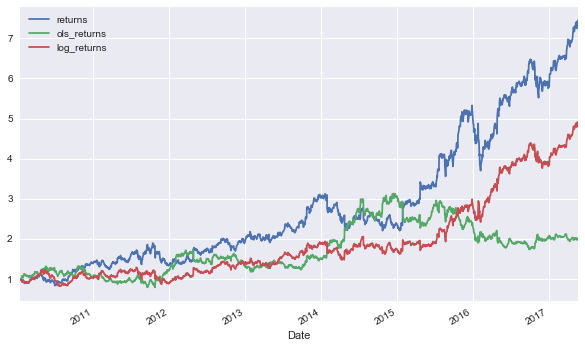

In [34]:
data[['returns', 'ols_returns', 'log_returns']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

## Deep Neural Network

In [35]:
import tensorflow as tf

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [37]:
mean = data['returns'].mean()

In [38]:
std = data['returns'].std()

In [39]:
print(mean, std)

0.00108427123518 0.0199275076794


In [40]:
fc = tf.contrib.layers.real_valued_column('returns', dimension=lags)

In [41]:
fcb = [tf.contrib.layers.bucketized_column(fc,
                    boundaries=[-0.0005, 0.0001, 0.0005])]

In [42]:
model = tf.contrib.learn.DNNClassifier(hidden_units=[50, 50],
                                       feature_columns=fcb)

In [43]:
def get_data():
    fc = {'returns': tf.constant(data[cols].values)}
    la = tf.constant((data['returns'] > 0).astype(int).values,
                     shape=[len(data), 1])
    return fc, la

In [44]:
model.fit(input_fn=get_data, steps=100)

DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x1195dfeb8>, 'hidden_units': [50, 50], 'feature_columns': (_BucketizedColumn(source_column=_RealValuedColumn(column_name='returns', dimension=5, default_value=None, dtype=tf.float32, normalizer=None), boundaries=(-0.0005, 0.0001, 0.0005)),), 'optimizer': None, 'activation_fn': <function relu at 0x11803e378>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [45]:
model.evaluate(input_fn=get_data, steps=1)

{'accuracy': 0.54913604,
 'accuracy/baseline_label_mean': 0.52429807,
 'accuracy/threshold_0.500000_mean': 0.54913604,
 'auc': 0.56181008,
 'global_step': 100,
 'labels/actual_label_mean': 0.52429807,
 'labels/prediction_mean': 0.52496111,
 'loss': 0.68702751,
 'precision/positive_threshold_0.500000_mean': 0.54815865,
 'recall/positive_threshold_0.500000_mean': 0.7971164}

In [46]:
data['dnn_pred'] = list(model.predict(input_fn=get_data))
data['dnn_pred'] = np.where(data['dnn_pred'] > 0, 1.0, -1.0)

In [47]:
data['dnn_returns'] = data['returns'] * data['dnn_pred']

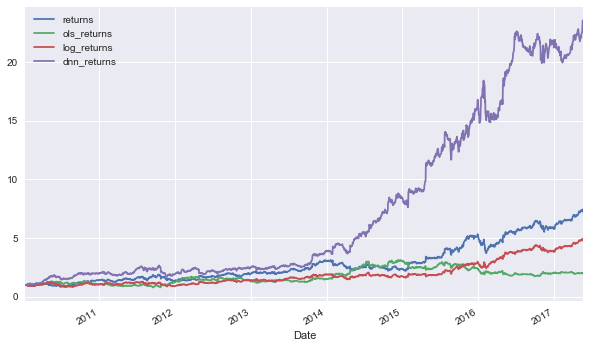

In [48]:
data[['returns', 'ols_returns', 'log_returns', 'dnn_returns']].cumsum(
        ).apply(np.exp).plot();